<a href="https://colab.research.google.com/github/kumaran1992/Deep_learning/blob/master/Beans_Leaf_Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
print(tf.__version__)

2.2.0


In [27]:
(training_set,validation_set),dataset_info = tfds.load('beans',split=['train','test'],as_supervised=True,with_info=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete61VR35/beans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete61VR35/beans-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incomplete61VR35/beans-test.tfrecord


Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [28]:
dataset_info

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.
',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://gi

In [31]:
num_classes = dataset_info.features['label'].num_classes
labels = dataset_info.features['label'].names

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

print(f'Total number of classes are {num_classes}')
print(f'The labels of dataset are {labels}')
print(f'Training examples: {num_training_examples} and Validation examples: {num_validation_examples}')


Total number of classes are 3
The labels of dataset are ['angular_leaf_spot', 'bean_rust', 'healthy']
Training examples: 1034 and Validation examples: 128


In [0]:
image_res = 224

batch_size = 32

def format_image(image,label):
  image = tf.image.resize(image,(image_res, image_res))/255.0
  return image,label

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(batch_size).prefetch(1)

validation_batches = validation_set.map(format_image).batch(batch_size).prefetch(1)

In [0]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(url,input_shape = (image_res,image_res,3))

#Freezing the pre-trained model by turning off trainable variable

feature_extractor.trainable = False

In [35]:

#Adding the last layer with pre-trained model

model = tf.keras.Sequential([feature_extractor,layers.Dense(num_classes)])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [41]:

#Fitting the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
epochs = 4

history = model.fit(train_batches, epochs=epochs, validation_data=validation_batches)

Epoch 1/4
33/33 [==============================] - 37s 1s/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 0.3070 - val_accuracy: 0.8750
Epoch 2/4
33/33 [==============================] - 37s 1s/step - loss: 0.0228 - accuracy: 0.9990 - val_loss: 0.2601 - val_accuracy: 0.8906
Epoch 3/4
33/33 [==============================] - 37s 1s/step - loss: 0.0199 - accuracy: 1.0000 - val_loss: 0.2678 - val_accuracy: 0.8984
Epoch 4/4
33/33 [==============================] - 37s 1s/step - loss: 0.0179 - accuracy: 1.0000 - val_loss: 0.2595 - val_accuracy: 0.8984


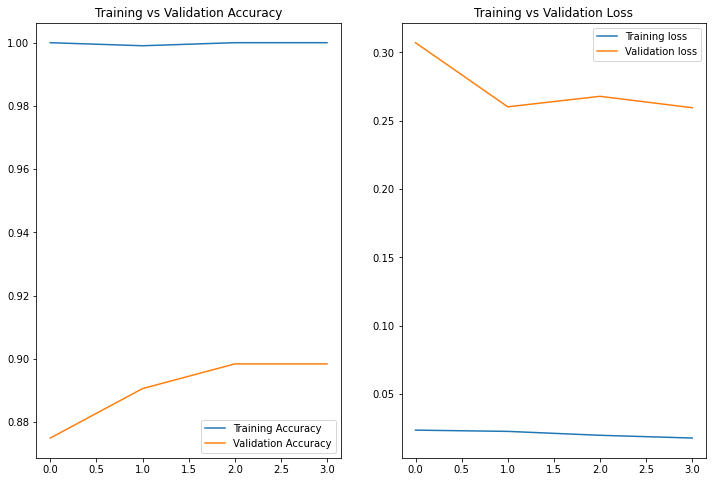

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Training Accuracy')
plt.plot(epochs_range,val_acc,label='Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range,val_loss,label = 'Validation loss')
plt.legend(loc = 'upper right')
plt.title('Training vs Validation Loss')
plt.show()

In [43]:
#creating batch and making predictons
labels = np.array(labels)

labels

array(['angular_leaf_spot', 'bean_rust', 'healthy'], dtype='<U17')

In [44]:
image_batch, label_batch = next(iter(train_batches))

image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch,axis=1)
predicted_class_names = labels[predicted_ids]

print(predicted_class_names)

['angular_leaf_spot' 'angular_leaf_spot' 'bean_rust' 'angular_leaf_spot'
 'angular_leaf_spot' 'angular_leaf_spot' 'healthy' 'healthy' 'healthy'
 'bean_rust' 'healthy' 'bean_rust' 'healthy' 'angular_leaf_spot'
 'angular_leaf_spot' 'angular_leaf_spot' 'healthy' 'healthy' 'bean_rust'
 'angular_leaf_spot' 'angular_leaf_spot' 'bean_rust' 'bean_rust'
 'angular_leaf_spot' 'angular_leaf_spot' 'angular_leaf_spot'
 'angular_leaf_spot' 'angular_leaf_spot' 'angular_leaf_spot' 'healthy'
 'healthy' 'healthy']


In [45]:
print('Labels: ',label_batch)
print('Predictions: ',predicted_ids)


Labels:  [0 0 1 0 0 0 2 2 2 1 2 1 2 0 0 0 2 2 1 0 0 1 1 0 0 0 0 0 0 2 2 2]
Predictions:  [0 0 1 0 0 0 2 2 2 1 2 1 2 0 0 0 2 2 1 0 0 1 1 0 0 0 0 0 0 2 2 2]


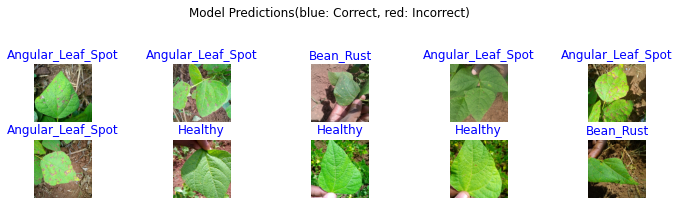

In [63]:
plt.figure(figsize =(12,8))
for n in range(10):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace=0.3)
  plt.imshow(image_batch[n])
  color = 'blue' if predicted_ids[n] == label_batch[n] else 'red'
  plt.title(predicted_class_names[n].title(), color = color)
  plt.axis('off')
  _ = plt.suptitle('Model Predictions(blue: Correct, red: Incorrect)')